<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/kapitza-pendulum-nworbehc/blob/main/Kapitza_Pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PSEUDOCODE FOR KAPITZA PENDULUM**

1. **Import packages**
    - numpy, scipy.integrate for solve_ivp
    - matplotlib.pyplot to plot some graphs

2. **Define the equation of motion**
  - For the pendulum:
$$\theta'' + 2\zeta\theta' + (\epsilon^{2} - \alpha\cos\theta)\sin\theta = 0$$

$$ \zeta = \gamma/\omega_{d} $$
$$ \epsilon = \omega_{0}/\omega_{d} $$
$$ \alpha = y_{0}/l $$
$$ \tau = \omega_{d}t $$
$$ \omega_0 = \sqrt(g/l) $$

  - In the form of solve_ivp:
$$ \theta'' = - 2\zeta\theta' - (\epsilon^{2} - \alpha\cos\theta)\sin\theta $$

  - A solution where the angle is 0 or 2$\pi$ would represent the pendulum hanging straight down
  - A solution where the angle is $\pi$ would represent the pendulum being inverted. This is the solution we want!

3. **Define functions**
    - `kapitza_pendulum(tau, y, epsilon, alpha, zeta)`
      - This will return the equation of motion for the pendulum
    - `average_long_timescale_response(epsilon, alpha, zeta, n_decay=100, delta_theta=0.01)`
      - This will solve our equation of motion using solve_ivp and average for long time scales, returns solution and averaged time
      - If the value of theta is consistent for long values of tau, the solution can be considered stable. If it spins off to large angles or otherwise isn't consistent, it can be considered unstable.
      - Using cos(theta) is useful to show the long term behavior in case the theta graph spins far from theta=0 before settling down
      
    - `alpha_critical(epsilon, zeta, coef, translation, exponent, intercept)`
      - This is our guess for the inverted state, returns alpha

5. **Define parameters**
   - omega_d : driven frequency
   - g : gravitational acceleration
   - l : length of pendulum
   - gamma : damping constant
   - t_min, t_max : starting and ending time of the simulation
   - t_span : defined as the difference between t_min and t_max
   - theta_0 : initial condition of the angle
   - ang_vel_0 : initial condition of the angular velocity

5. **Iterate through a mesh of alpha and epsilon**
  - Create lists for a range of epsilon/alpha values using linspace
  - Write a for loop to repeatedly solve the equation of motion for all combinations of epsilon/alpha in those lists
  - Return a list of lists that contains solutions for all combinations

6. **Graph alpha vs epsilon**
  - Plot on a contour map so we can see visually where the solutions are
  - Plot equation for alpha depending on epsilon and other coefficients to guess at a relationship

7. **Test solutions to make sure that they are sensible**
  - Analyze using graphs of theta vs tau and cos(theta) vs tau

8. **Stability analysis**
  - Propose an equation that relates alpha to epsilon

In [2]:
#IMPORT PACKAGES
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

### Define the functions for the pendulum's equation of motion and the average long time response (will be used to graph)

In [3]:
#Define functions
#pendulum function
def kapitza_pendulum(tau, y, epsilon, alpha, zeta):
    """
    Defines equation of motion for our pendulum

    tau     = dimensionless time
    y       = state variable, defined as theta and ang_vel
    epsilon = ratio of natural frequency to driven frequency, = omega_0/omega_d
    alpha = driving strength, relative displacement of the pivot to the pendulum arm, = y_0/l
    zeta = dimensionless damping

    Returns: dy/dtau = dime derivatives of state variables
    """
    theta, ang_vel = y # unpacking our state variable
    dtheta_dtau = ang_vel # first derivative
    d2theta_dtau2 = -2*zeta*dtheta_dtau - (epsilon**2 - alpha*np.cos(tau))*np.sin(theta)  # second derivative
    dy_dtau = np.array([dtheta_dtau, d2theta_dtau2])
    return dy_dtau

#function that averages cos(theta), solves equaiton of motion
def average_long_timescale_response(epsilon, alpha, zeta, n_decay=100, delta_theta=0.01):
  tau_min = 0                     #tau parameters
  tau_max = n_decay/(2*zeta)
  tau_span = [tau_min, tau_max]

  delta_theta = 0.01              #initial conditions
  theta_0 = np.pi - delta_theta   # we don't want to be exactly at inverted state, delta_theta is small deviation from pi
  ang_vel_0 = 0
  y_0 = [theta_0, ang_vel_0]

  solution = solve_ivp(kapitza_pendulum,          #solves equation of motion
                    tau_span, y_0,
                    args=(epsilon, alpha, zeta),
                    methods='Radau',
                    dense_output=True)

  tau_averaging_range = np.linspace((n_decay-1)/(2*zeta), n_decay/(2*zeta), 1000) #averages over the last decay
  cos_theta_averaging = np.mean(np.cos(solution.sol(tau_averaging_range)[0]))
  return cos_theta_averaging, solution

def alpha_critical(epsilon, zeta, coef, translation, exponent, intercept):
  """
  Defines the boundary of the inverted state

  epsilon : dimensionless frequency
  zeta : dimensionless damping
  coef : tuning paramete

  Returns: alpha : relative displacement of the pivot to the pendulum arm
  """
  alpha = coef*(epsilon-translation)**exponent - intercept  #totally random starter guess
  return alpha

### Iterate through a mesh of epsilon and alpha
- extract long timescale response
- plot alpha vs epsilon on contour graph

In [6]:
%%time
#inputs
epsilon_list = np.linspace(0.01, 2, 30)   #dimensionless angular frequency
alpha_list = np.linspace(0, 2, 30)     #dimensionless drive strength
zeta = 0.1        #dimensionless damping

#number of decay times we want to integrate over
n_decay = 1000

#initialize mesh for average long time scale response
cos_theta_mesh = np.zeros((len(alpha_list), len(epsilon_list)))
#print(cos_theta_mesh)

for i, alpha in enumerate(alpha_list):
  for j, epsilon in enumerate(epsilon_list):
    cos_theta_averaging, solution = average_long_timescale_response(epsilon, alpha, zeta, n_decay)
    cos_theta_mesh[i,j] = cos_theta_averaging

CPU times: user 8min 16s, sys: 658 ms, total: 8min 17s
Wall time: 8min 21s


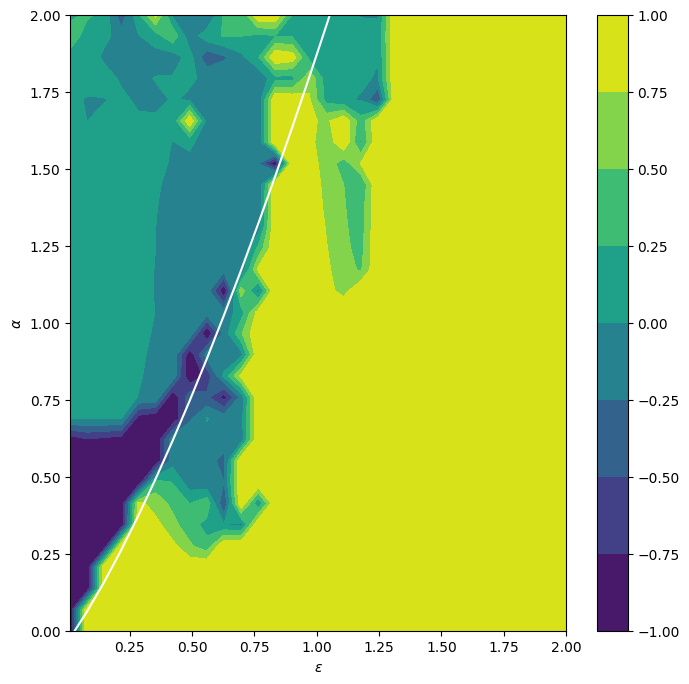

In [13]:
plt.figure(figsize=(8,8))
plt.contourf(epsilon_list, alpha_list, cos_theta_mesh)
#coef, translation, exponent, intercept
plt.plot(epsilon_list, alpha_critical(epsilon_list, zeta, 1.6, -0.2, np.sqrt(2), 0.2),'w')
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$\epsilon$')
plt.ylim(0,2)
plt.colorbar()
plt.show()

### Test solutions proposed by the graph
  -For example: epsilon=0.25 and alpha=0.5 seemed sensible solutions that were inverted from the graph, so they are tested here

/usr/local/lib/python3.12/dist-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `methods`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


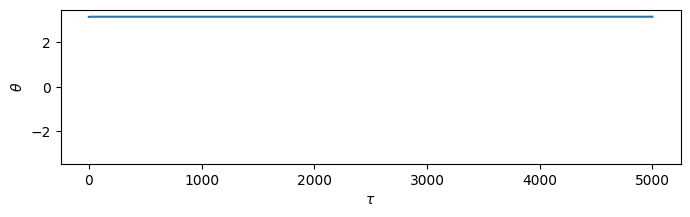

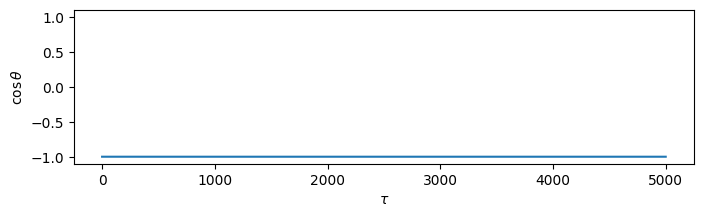

In [17]:
#DEFINE PARAMETERS

#inputs
epsilon = 0.25    #dimensionless angular frequency
alpha = 0.5       #dimensionless drive strength
zeta = 0.1        #dimensionless damping

#number of decay times we want to integrate over
n_decay = 1000

tau_min = 0                     #tau parameters
tau_max = n_decay/(2*zeta)
tau_span = [tau_min, tau_max]
cos_theta_averaging, solution = average_long_timescale_response(epsilon, alpha, zeta, n_decay)

#PLOTS
tau_plot = np.linspace(tau_min, tau_max, 1000)
theta_plot = solution.sol(tau_plot)[0]

#basic_plot(tau_plot, theta_plot, xlabel=r'$\tau$', ylabel=r'$\theta$', figsize=(6,2))
plt.figure(figsize=(8,2))
plt.plot(tau_plot, theta_plot)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\theta$')
plt.ylim(-np.pi*1.1, np.pi*1.1)
plt.show()

#using cosine
plt.figure(figsize=(8,2))
plt.plot(tau_plot, np.cos(theta_plot))
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\cos\theta$')
plt.ylim(-1.1, 1.1)
plt.show()

## Stability Analysis

- After iterating over many points and a large range of alpha and epsilon, it could be determined by the countour graph that there were indeed stable solutions of the inverted pendulum!

#Observations
- For very low values of $\epsilon$, there were stable inverted solutions for all values of $\alpha$ up until around $\alpha$ = 0.6

- For higher values of $\epsilon$, there were some stable inverted solutions, but all of them had $\alpha$ values that were higher than the corresponding $\epsilon$. This implied a relationship between $\epsilon$ and the values of $\alpha$ that had an inverted solution

- The inverted solutions got sparser as both values increased, and in the surveyed mesh there were no solutions higher than about
$\epsilon$ = 0.87 and $\alpha$ = 1.5. This implied that their relationship was nonlinear.

#Proposed Relationship
- To guess at the relationship between $\epsilon$ and $\alpha$, I started with the general form of $\alpha = a(\epsilon - b)^c - d$. This form allowed me to manipulate all kinds of coefficients to change the shape of my line of best fit
- a, b, c, and d are represented in the code as the variables coef, translation, exponent, and intercept respectively.
- After much testing, I arrived at the following values for my coefficients:
  - a (coef) = 1.6
  - b (translation) = -0.2
  - c (exponent) = $\sqrt2$
  - d (intercept) = 0.2
- When substituted into the general form, this gave me my proposed equation:
$\alpha = 1.6(\epsilon + 0.2)^\sqrt2 - 0.2$
- I selected these conditions for my proposed equation because the line they generated on the contour graph very closely matched the boundary of the inverted solutions, and there were no inverted solutions lying past the boundary.
- This equation only presents an approximation of the boundary conditions for inverted pendulum solutions. There are many non-stable or non-inverted solutions that lie to the left of this curve.
  - If we were to create a more consistent model, I would experiment with creating a second equation that could model boundary solutions from the other side of the graph with lower \$epsilon$ values.
  - Surveying a larger region could potentially reveal a maximum value of alpha or epsilon beyond which there are no further inverted solutions. Should this be the case, the equations would be modified to include any vertical or horizontal asymptotes that may appear.

